## Importing Libraries

In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
import PIL
import glob
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import os, shutil
import warnings
import sys
import shutil
warnings.filterwarnings('ignore')

# Importing Dataset

In [3]:
import splitfolders
class config:
    
    data_path = 'Dataset/'
    
    path_train = "./output/train"
    path_test = "./output/test"

In [4]:
splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.8, .2))

Copying files: 175 files [00:00, 1602.60 files/s]


In [5]:
BATCH_SIZE = 64
IMAGE_SHAPE = (224, 224)

In [6]:
TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 135 images belonging to 3 classes.
Found 37 images belonging to 3 classes.


In [8]:
class_map = dict([(v, k) for k, v in train_gen.class_indices.items()])
print(class_map)

{0: 'Half ripe', 1: 'Ripe', 2: 'Unripe'}


In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

# MobileNet

In [10]:
inc = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(3, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m])
r2 = model.fit(train_gen, validation_data=val_gen, epochs=100, steps_per_epoch=len(train_gen), validation_steps=len(val_gen))
history = r2.history

Epoch 1/100
3/3 [==============================] - 4s 506ms/step - loss: 4.9689 - accuracy: 0.4074 - f1_score: 0.4561 - recall_m: 0.4561 - precision_m: 0.4561 - specificity_m: 0.7281 - sensitivity_m: 0.4561 - val_loss: 5.8403 - val_accuracy: 0.4324 - val_f1_score: 0.4324 - val_recall_m: 0.4324 - val_precision_m: 0.4324 - val_specificity_m: 0.7162 - val_sensitivity_m: 0.4324
Epoch 2/100
3/3 [==============================] - 1s 182ms/step - loss: 0.9271 - accuracy: 0.8889 - f1_score: 0.8795 - recall_m: 0.8795 - precision_m: 0.8795 - specificity_m: 0.9397 - sensitivity_m: 0.8795 - val_loss: 7.2553 - val_accuracy: 0.3514 - val_f1_score: 0.3514 - val_recall_m: 0.3514 - val_precision_m: 0.3514 - val_specificity_m: 0.6757 - val_sensitivity_m: 0.3514
Epoch 3/100
3/3 [==============================] - 1s 338ms/step - loss: 0.5112 - accuracy: 0.8889 - f1_score: 0.8795 - recall_m: 0.8795 - precision_m: 0.8795 - specificity_m: 0.9397 - sensitivity_m: 0.8795 - val_loss: 5.9166 - val_accuracy: 0.29

Epoch 23/100
3/3 [==============================] - 1s 330ms/step - loss: 0.5080 - accuracy: 0.9037 - f1_score: 0.8475 - recall_m: 0.8475 - precision_m: 0.8475 - specificity_m: 0.9237 - sensitivity_m: 0.8475 - val_loss: 3.0889 - val_accuracy: 0.6216 - val_f1_score: 0.6216 - val_recall_m: 0.6216 - val_precision_m: 0.6216 - val_specificity_m: 0.8108 - val_sensitivity_m: 0.6216
Epoch 24/100
3/3 [==============================] - 1s 345ms/step - loss: 0.4445 - accuracy: 0.9111 - f1_score: 0.8527 - recall_m: 0.8527 - precision_m: 0.8527 - specificity_m: 0.9263 - sensitivity_m: 0.8527 - val_loss: 3.3825 - val_accuracy: 0.5405 - val_f1_score: 0.5405 - val_recall_m: 0.5405 - val_precision_m: 0.5405 - val_specificity_m: 0.7703 - val_sensitivity_m: 0.5405
Epoch 25/100
3/3 [==============================] - 1s 177ms/step - loss: 0.3758 - accuracy: 0.9259 - f1_score: 0.8631 - recall_m: 0.8631 - precision_m: 0.8631 - specificity_m: 0.9315 - sensitivity_m: 0.8631 - val_loss: 6.4582 - val_accuracy: 0

Epoch 45/100
3/3 [==============================] - 1s 322ms/step - loss: 0.1970 - accuracy: 0.9556 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9844 - sensitivity_m: 0.9688 - val_loss: 2.7480 - val_accuracy: 0.6486 - val_f1_score: 0.6486 - val_recall_m: 0.6486 - val_precision_m: 0.6486 - val_specificity_m: 0.8243 - val_sensitivity_m: 0.6486
Epoch 46/100
3/3 [==============================] - 1s 333ms/step - loss: 0.1971 - accuracy: 0.9704 - f1_score: 0.9368 - recall_m: 0.9368 - precision_m: 0.9368 - specificity_m: 0.9684 - sensitivity_m: 0.9368 - val_loss: 3.4832 - val_accuracy: 0.7027 - val_f1_score: 0.7027 - val_recall_m: 0.7027 - val_precision_m: 0.7027 - val_specificity_m: 0.8514 - val_sensitivity_m: 0.7027
Epoch 47/100
3/3 [==============================] - 1s 338ms/step - loss: 0.2333 - accuracy: 0.9556 - f1_score: 0.9661 - recall_m: 0.9635 - precision_m: 0.9687 - specificity_m: 0.9844 - sensitivity_m: 0.9635 - val_loss: 4.0649 - val_accuracy: 0

Epoch 67/100
3/3 [==============================] - 1s 187ms/step - loss: 0.1104 - accuracy: 0.9630 - f1_score: 0.9740 - recall_m: 0.9740 - precision_m: 0.9740 - specificity_m: 0.9870 - sensitivity_m: 0.9740 - val_loss: 1.5019 - val_accuracy: 0.6757 - val_f1_score: 0.6757 - val_recall_m: 0.6757 - val_precision_m: 0.6757 - val_specificity_m: 0.8378 - val_sensitivity_m: 0.6757
Epoch 68/100
3/3 [==============================] - 1s 337ms/step - loss: 0.4237 - accuracy: 0.9556 - f1_score: 0.9263 - recall_m: 0.9263 - precision_m: 0.9263 - specificity_m: 0.9632 - sensitivity_m: 0.9263 - val_loss: 2.0893 - val_accuracy: 0.6757 - val_f1_score: 0.6757 - val_recall_m: 0.6757 - val_precision_m: 0.6757 - val_specificity_m: 0.8378 - val_sensitivity_m: 0.6757
Epoch 69/100
3/3 [==============================] - 1s 345ms/step - loss: 0.6656 - accuracy: 0.9037 - f1_score: 0.8051 - recall_m: 0.8051 - precision_m: 0.8051 - specificity_m: 0.9025 - sensitivity_m: 0.8051 - val_loss: 2.8510 - val_accuracy: 0

Epoch 89/100
3/3 [==============================] - 1s 228ms/step - loss: 0.1034 - accuracy: 0.9630 - f1_score: 0.9315 - recall_m: 0.9315 - precision_m: 0.9315 - specificity_m: 0.9658 - sensitivity_m: 0.9315 - val_loss: 12.7110 - val_accuracy: 0.2973 - val_f1_score: 0.2973 - val_recall_m: 0.2973 - val_precision_m: 0.2973 - val_specificity_m: 0.6486 - val_sensitivity_m: 0.2973
Epoch 90/100
3/3 [==============================] - 1s 255ms/step - loss: 0.0779 - accuracy: 0.9704 - f1_score: 0.9368 - recall_m: 0.9368 - precision_m: 0.9368 - specificity_m: 0.9684 - sensitivity_m: 0.9368 - val_loss: 13.6837 - val_accuracy: 0.2973 - val_f1_score: 0.2973 - val_recall_m: 0.2973 - val_precision_m: 0.2973 - val_specificity_m: 0.6486 - val_sensitivity_m: 0.2973
Epoch 91/100
3/3 [==============================] - 1s 345ms/step - loss: 0.1860 - accuracy: 0.9630 - f1_score: 0.9315 - recall_m: 0.9315 - precision_m: 0.9315 - specificity_m: 0.9658 - sensitivity_m: 0.9315 - val_loss: 12.8183 - val_accuracy

In [12]:
model.save('models/mobilenet.h5')

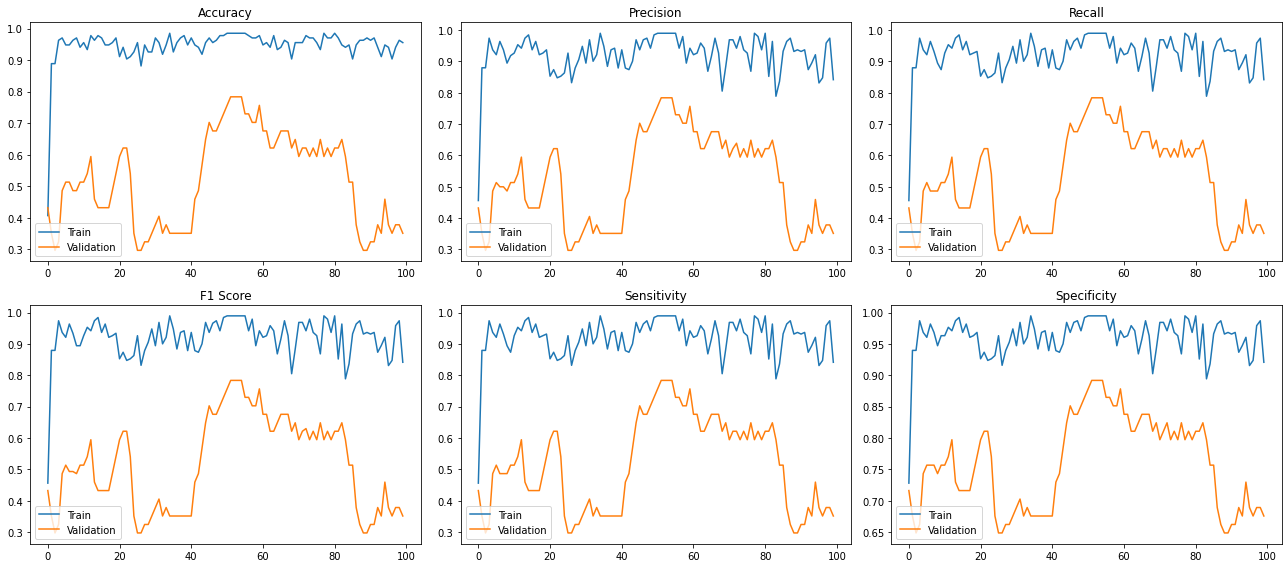

In [13]:
history = r2

# Extract the metrics from history
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

# Create a figure and subplot for each metric
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[0, 2].plot(train_recall, label='Train')
axs[0, 2].plot(val_recall, label='Validation')
axs[0, 2].set_title('Recall')
axs[0, 2].legend()

# Plot F1 score
axs[1, 0].plot(train_f1, label='Train')
axs[1, 0].plot(val_f1, label='Validation')
axs[1, 0].set_title('F1 Score')
axs[1, 0].legend()

# Plot sensitivity
axs[1, 1].plot(train_sensitivity, label='Train')
axs[1, 1].plot(val_sensitivity, label='Validation')
axs[1, 1].set_title('Sensitivity')
axs[1, 1].legend()

# Plot specificity
axs[1, 2].plot(train_specificity, label='Train')
axs[1, 2].plot(val_specificity, label='Validation')
axs[1, 2].set_title('Specificity')
axs[1, 2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


1/1 [==============================] - 0s 140ms/step - loss: 7.9277 - accuracy: 0.3514 - f1_score: 0.3514 - recall_m: 0.3514 - precision_m: 0.3514 - specificity_m: 0.6757 - sensitivity_m: 0.3514


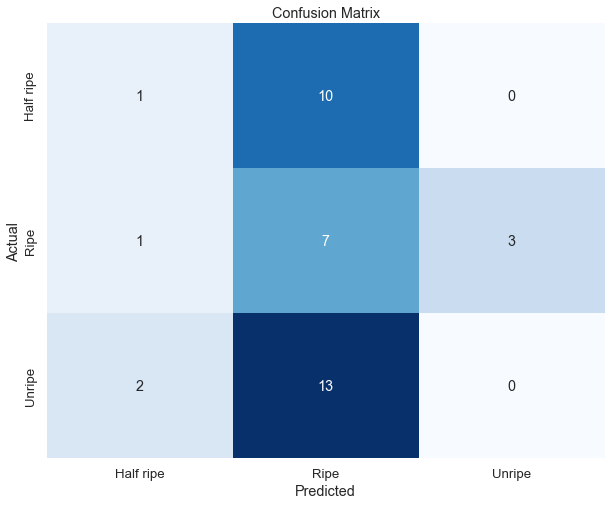

In [14]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
a = history.history['accuracy'][-1]
f = history.history['f1_score'][-1]
p = history.history['precision_m'][-1]
r = history.history['recall_m'][-1]

In [16]:
print('Accuracy = ' + str(a * 100))
print('Precision = ' + str(p * 100))
print('F1 Score = ' + str(f * 100))
print('Recall = ' + str(r * 100))

Accuracy = 95.55555582046509
Precision = 84.15178656578064
F1 Score = 84.15178656578064
Recall = 84.15178656578064


# Extension

# CNN

In [17]:
model = Sequential() # model object

# Add Layers
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[224, 224, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25690240  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m])
r2 = model.fit(train_gen, validation_data=val_gen, epochs=100, steps_per_epoch=len(train_gen), validation_steps=len(val_gen))
history=r2

Epoch 1/100
3/3 [==============================] - 1s 252ms/step - loss: 3.2881 - accuracy: 0.3926 - f1_score: 0.3207 - recall_m: 0.3207 - precision_m: 0.3207 - specificity_m: 0.8270 - sensitivity_m: 0.3207 - val_loss: 2.5711 - val_accuracy: 0.2973 - val_f1_score: 0.3014 - val_recall_m: 0.2973 - val_precision_m: 0.3056 - val_specificity_m: 0.6622 - val_sensitivity_m: 0.2973
Epoch 2/100
3/3 [==============================] - 1s 292ms/step - loss: 1.7239 - accuracy: 0.2741 - f1_score: 0.2594 - recall_m: 0.2411 - precision_m: 0.2868 - specificity_m: 0.6908 - sensitivity_m: 0.2411 - val_loss: 0.9889 - val_accuracy: 0.6216 - val_f1_score: 0.1026 - val_recall_m: 0.0541 - val_precision_m: 1.0000 - val_specificity_m: 1.0000 - val_sensitivity_m: 0.0541
Epoch 3/100
3/3 [==============================] - 1s 292ms/step - loss: 1.0308 - accuracy: 0.5185 - f1_score: 0.3313 - recall_m: 0.2307 - precision_m: 0.5900 - specificity_m: 0.9215 - sensitivity_m: 0.2307 - val_loss: 0.9694 - val_accuracy: 0.67

Epoch 23/100
3/3 [==============================] - 1s 300ms/step - loss: 0.0698 - accuracy: 0.9630 - f1_score: 0.9315 - recall_m: 0.9315 - precision_m: 0.9315 - specificity_m: 0.9658 - sensitivity_m: 0.9315 - val_loss: 0.4091 - val_accuracy: 0.8108 - val_f1_score: 0.8108 - val_recall_m: 0.8108 - val_precision_m: 0.8108 - val_specificity_m: 0.9054 - val_sensitivity_m: 0.8108
Epoch 24/100
3/3 [==============================] - 1s 175ms/step - loss: 0.0522 - accuracy: 0.9852 - f1_score: 0.9896 - recall_m: 0.9896 - precision_m: 0.9896 - specificity_m: 0.9948 - sensitivity_m: 0.9896 - val_loss: 0.4292 - val_accuracy: 0.8108 - val_f1_score: 0.7945 - val_recall_m: 0.7838 - val_precision_m: 0.8056 - val_specificity_m: 0.9054 - val_sensitivity_m: 0.7838
Epoch 25/100
3/3 [==============================] - 1s 304ms/step - loss: 0.0898 - accuracy: 0.9704 - f1_score: 0.9368 - recall_m: 0.9368 - precision_m: 0.9368 - specificity_m: 0.9684 - sensitivity_m: 0.9368 - val_loss: 1.0845 - val_accuracy: 0

Epoch 45/100
3/3 [==============================] - 1s 301ms/step - loss: 0.0284 - accuracy: 0.9852 - f1_score: 0.9896 - recall_m: 0.9896 - precision_m: 0.9896 - specificity_m: 0.9948 - sensitivity_m: 0.9896 - val_loss: 1.1015 - val_accuracy: 0.6757 - val_f1_score: 0.6757 - val_recall_m: 0.6757 - val_precision_m: 0.6757 - val_specificity_m: 0.8378 - val_sensitivity_m: 0.6757
Epoch 46/100
3/3 [==============================] - 1s 180ms/step - loss: 0.0227 - accuracy: 0.9926 - f1_score: 0.9524 - recall_m: 0.9524 - precision_m: 0.9524 - specificity_m: 0.9762 - sensitivity_m: 0.9524 - val_loss: 1.1052 - val_accuracy: 0.7027 - val_f1_score: 0.7027 - val_recall_m: 0.7027 - val_precision_m: 0.7027 - val_specificity_m: 0.8514 - val_sensitivity_m: 0.7027
Epoch 47/100
3/3 [==============================] - 1s 303ms/step - loss: 0.0604 - accuracy: 0.9778 - f1_score: 0.9844 - recall_m: 0.9844 - precision_m: 0.9844 - specificity_m: 0.9922 - sensitivity_m: 0.9844 - val_loss: 1.3190 - val_accuracy: 0

Epoch 67/100
3/3 [==============================] - 1s 169ms/step - loss: 0.0220 - accuracy: 0.9852 - f1_score: 0.9896 - recall_m: 0.9896 - precision_m: 0.9896 - specificity_m: 0.9948 - sensitivity_m: 0.9896 - val_loss: 0.6875 - val_accuracy: 0.7838 - val_f1_score: 0.7838 - val_recall_m: 0.7838 - val_precision_m: 0.7838 - val_specificity_m: 0.8919 - val_sensitivity_m: 0.7838
Epoch 68/100
3/3 [==============================] - 1s 199ms/step - loss: 0.0301 - accuracy: 0.9852 - f1_score: 0.9896 - recall_m: 0.9896 - precision_m: 0.9896 - specificity_m: 0.9948 - sensitivity_m: 0.9896 - val_loss: 0.6557 - val_accuracy: 0.8108 - val_f1_score: 0.8108 - val_recall_m: 0.8108 - val_precision_m: 0.8108 - val_specificity_m: 0.9054 - val_sensitivity_m: 0.8108
Epoch 69/100
3/3 [==============================] - 1s 300ms/step - loss: 0.0281 - accuracy: 0.9852 - f1_score: 0.9896 - recall_m: 0.9896 - precision_m: 0.9896 - specificity_m: 0.9948 - sensitivity_m: 0.9896 - val_loss: 0.6857 - val_accuracy: 0

Epoch 89/100
3/3 [==============================] - 1s 167ms/step - loss: 0.0210 - accuracy: 0.9926 - f1_score: 0.9948 - recall_m: 0.9948 - precision_m: 0.9948 - specificity_m: 0.9974 - sensitivity_m: 0.9948 - val_loss: 0.7361 - val_accuracy: 0.7838 - val_f1_score: 0.7606 - val_recall_m: 0.7297 - val_precision_m: 0.7941 - val_specificity_m: 0.9054 - val_sensitivity_m: 0.7297
Epoch 90/100
3/3 [==============================] - 1s 210ms/step - loss: 0.0331 - accuracy: 0.9926 - f1_score: 0.9948 - recall_m: 0.9948 - precision_m: 0.9948 - specificity_m: 0.9974 - sensitivity_m: 0.9948 - val_loss: 0.5422 - val_accuracy: 0.7838 - val_f1_score: 0.7671 - val_recall_m: 0.7568 - val_precision_m: 0.7778 - val_specificity_m: 0.8919 - val_sensitivity_m: 0.7568
Epoch 91/100
3/3 [==============================] - 1s 165ms/step - loss: 0.0546 - accuracy: 0.9704 - f1_score: 0.9792 - recall_m: 0.9792 - precision_m: 0.9792 - specificity_m: 0.9896 - sensitivity_m: 0.9792 - val_loss: 0.4475 - val_accuracy: 0

In [19]:
model.save('models/cnn.h5')

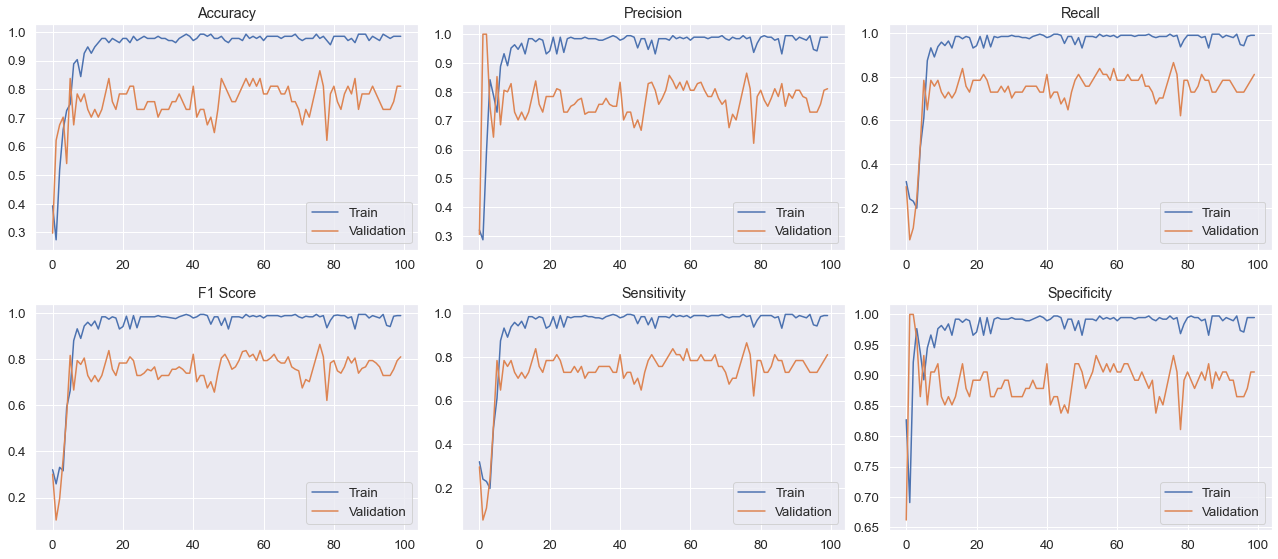

In [20]:
history = r2

# Extract the metrics from history
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

# Create a figure and subplot for each metric
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[0, 2].plot(train_recall, label='Train')
axs[0, 2].plot(val_recall, label='Validation')
axs[0, 2].set_title('Recall')
axs[0, 2].legend()

# Plot F1 score
axs[1, 0].plot(train_f1, label='Train')
axs[1, 0].plot(val_f1, label='Validation')
axs[1, 0].set_title('F1 Score')
axs[1, 0].legend()

# Plot sensitivity
axs[1, 1].plot(train_sensitivity, label='Train')
axs[1, 1].plot(val_sensitivity, label='Validation')
axs[1, 1].set_title('Sensitivity')
axs[1, 1].legend()

# Plot specificity
axs[1, 2].plot(train_specificity, label='Train')
axs[1, 2].plot(val_specificity, label='Validation')
axs[1, 2].set_title('Specificity')
axs[1, 2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


1/1 [==============================] - 0s 139ms/step - loss: 0.4807 - accuracy: 0.8108 - f1_score: 0.8108 - recall_m: 0.8108 - precision_m: 0.8108 - specificity_m: 0.9054 - sensitivity_m: 0.8108


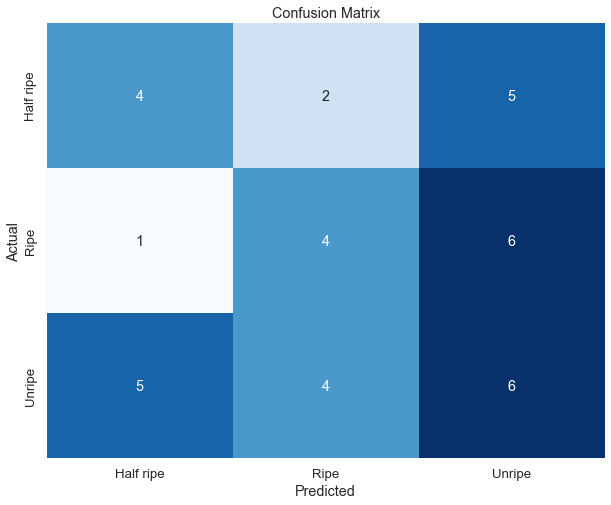

In [21]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [22]:
a1 = history.history['accuracy'][-1]
f1 = history.history['f1_score'][-1]
p1 = history.history['precision_m'][-1]
r1 = history.history['recall_m'][-1]

In [23]:
print('Accuracy = ' + str(a1 * 100))
print('Precision = ' + str(p1 * 100))
print('F1 Score = ' + str(f1 * 100))
print('Recall = ' + str(r1 * 100))

Accuracy = 98.51852059364319
Precision = 98.95833134651184
F1 Score = 98.95833134651184
Recall = 98.95833134651184


# Xception

In [24]:
inc = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(3, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [25]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m])
r2 = model.fit(train_gen, validation_data=val_gen, epochs=100, steps_per_epoch=len(train_gen), validation_steps=len(val_gen))
history=r2

Epoch 1/100
3/3 [==============================] - 5s 892ms/step - loss: 1.2766 - accuracy: 0.3852 - f1_score: 0.2560 - recall_m: 0.2046 - precision_m: 0.4280 - specificity_m: 0.8006 - sensitivity_m: 0.2046 - val_loss: 0.9644 - val_accuracy: 0.7027 - val_f1_score: 0.6286 - val_recall_m: 0.5946 - val_precision_m: 0.6667 - val_specificity_m: 0.8514 - val_sensitivity_m: 0.5946
Epoch 2/100
3/3 [==============================] - 1s 263ms/step - loss: 0.9256 - accuracy: 0.7481 - f1_score: 0.1470 - recall_m: 0.0833 - precision_m: 0.6250 - specificity_m: 0.9974 - sensitivity_m: 0.0833 - val_loss: 1.1491 - val_accuracy: 0.5676 - val_f1_score: 0.5352 - val_recall_m: 0.5135 - val_precision_m: 0.5588 - val_specificity_m: 0.7973 - val_sensitivity_m: 0.5135
Epoch 3/100
3/3 [==============================] - 1s 489ms/step - loss: 0.6711 - accuracy: 0.7259 - f1_score: 0.5499 - recall_m: 0.5015 - precision_m: 0.6132 - specificity_m: 0.8237 - sensitivity_m: 0.5015 - val_loss: 2.2529 - val_accuracy: 0.56

Epoch 23/100
3/3 [==============================] - 1s 331ms/step - loss: 0.1395 - accuracy: 0.9704 - f1_score: 0.9310 - recall_m: 0.9211 - precision_m: 0.9416 - specificity_m: 0.9710 - sensitivity_m: 0.9211 - val_loss: 1.9787 - val_accuracy: 0.5946 - val_f1_score: 0.6111 - val_recall_m: 0.5946 - val_precision_m: 0.6286 - val_specificity_m: 0.8243 - val_sensitivity_m: 0.5946
Epoch 24/100
3/3 [==============================] - 1s 360ms/step - loss: 0.1036 - accuracy: 0.9481 - f1_score: 0.9211 - recall_m: 0.9211 - precision_m: 0.9211 - specificity_m: 0.9606 - sensitivity_m: 0.9211 - val_loss: 1.6984 - val_accuracy: 0.6757 - val_f1_score: 0.6757 - val_recall_m: 0.6757 - val_precision_m: 0.6757 - val_specificity_m: 0.8378 - val_sensitivity_m: 0.6757
Epoch 25/100
3/3 [==============================] - 1s 487ms/step - loss: 0.0583 - accuracy: 0.9778 - f1_score: 0.9420 - recall_m: 0.9420 - precision_m: 0.9420 - specificity_m: 0.9710 - sensitivity_m: 0.9420 - val_loss: 1.3335 - val_accuracy: 0

Epoch 45/100
3/3 [==============================] - 1s 265ms/step - loss: 0.1909 - accuracy: 0.9556 - f1_score: 0.7991 - recall_m: 0.7991 - precision_m: 0.7991 - specificity_m: 0.8996 - sensitivity_m: 0.7991 - val_loss: 1.2477 - val_accuracy: 0.8108 - val_f1_score: 0.8108 - val_recall_m: 0.8108 - val_precision_m: 0.8108 - val_specificity_m: 0.9054 - val_sensitivity_m: 0.8108
Epoch 46/100
3/3 [==============================] - 1s 474ms/step - loss: 0.1771 - accuracy: 0.9185 - f1_score: 0.9450 - recall_m: 0.9427 - precision_m: 0.9473 - specificity_m: 0.9740 - sensitivity_m: 0.9427 - val_loss: 1.8020 - val_accuracy: 0.6757 - val_f1_score: 0.6944 - val_recall_m: 0.6757 - val_precision_m: 0.7143 - val_specificity_m: 0.8649 - val_sensitivity_m: 0.6757
Epoch 47/100
3/3 [==============================] - 1s 266ms/step - loss: 0.2860 - accuracy: 0.8815 - f1_score: 0.8313 - recall_m: 0.8266 - precision_m: 0.8360 - specificity_m: 0.9185 - sensitivity_m: 0.8266 - val_loss: 1.7709 - val_accuracy: 0

Epoch 67/100
3/3 [==============================] - 1s 256ms/step - loss: 0.1099 - accuracy: 0.9704 - f1_score: 0.8943 - recall_m: 0.8943 - precision_m: 0.8943 - specificity_m: 0.9472 - sensitivity_m: 0.8943 - val_loss: 0.5453 - val_accuracy: 0.8919 - val_f1_score: 0.8919 - val_recall_m: 0.8919 - val_precision_m: 0.8919 - val_specificity_m: 0.9459 - val_sensitivity_m: 0.8919
Epoch 68/100
3/3 [==============================] - 1s 498ms/step - loss: 0.0912 - accuracy: 0.9481 - f1_score: 0.9211 - recall_m: 0.9211 - precision_m: 0.9211 - specificity_m: 0.9606 - sensitivity_m: 0.9211 - val_loss: 0.5813 - val_accuracy: 0.7838 - val_f1_score: 0.7838 - val_recall_m: 0.7838 - val_precision_m: 0.7838 - val_specificity_m: 0.8919 - val_sensitivity_m: 0.7838
Epoch 69/100
3/3 [==============================] - 1s 502ms/step - loss: 0.0784 - accuracy: 0.9704 - f1_score: 0.9368 - recall_m: 0.9368 - precision_m: 0.9368 - specificity_m: 0.9684 - sensitivity_m: 0.9368 - val_loss: 0.6666 - val_accuracy: 0

Epoch 89/100
3/3 [==============================] - 1s 263ms/step - loss: 0.0751 - accuracy: 0.9778 - f1_score: 0.9420 - recall_m: 0.9420 - precision_m: 0.9420 - specificity_m: 0.9710 - sensitivity_m: 0.9420 - val_loss: 4.9287 - val_accuracy: 0.6486 - val_f1_score: 0.6575 - val_recall_m: 0.6486 - val_precision_m: 0.6667 - val_specificity_m: 0.8378 - val_sensitivity_m: 0.6486
Epoch 90/100
3/3 [==============================] - 1s 265ms/step - loss: 0.1005 - accuracy: 0.9630 - f1_score: 0.8614 - recall_m: 0.8467 - precision_m: 0.8785 - specificity_m: 0.9472 - sensitivity_m: 0.8467 - val_loss: 3.7114 - val_accuracy: 0.6216 - val_f1_score: 0.6027 - val_recall_m: 0.5946 - val_precision_m: 0.6111 - val_specificity_m: 0.8108 - val_sensitivity_m: 0.5946
Epoch 91/100
3/3 [==============================] - 1s 259ms/step - loss: 0.0960 - accuracy: 0.9630 - f1_score: 0.8891 - recall_m: 0.8891 - precision_m: 0.8891 - specificity_m: 0.9446 - sensitivity_m: 0.8891 - val_loss: 2.0883 - val_accuracy: 0

In [26]:
model.save('models/xception.h5')

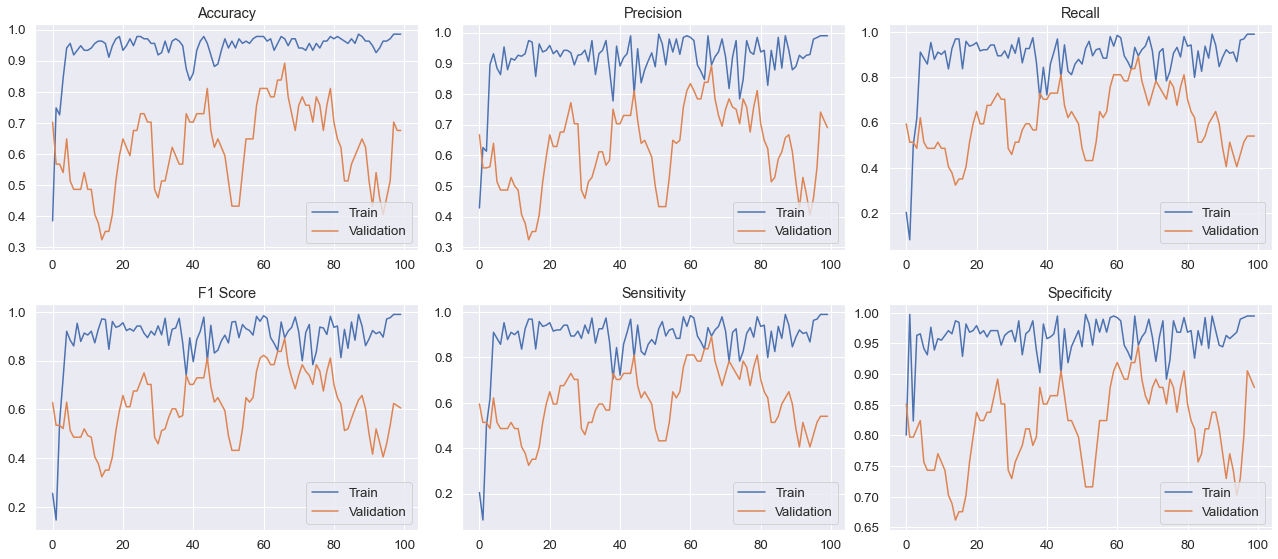

In [27]:
history = r2

# Extract the metrics from history
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

# Create a figure and subplot for each metric
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[0, 2].plot(train_recall, label='Train')
axs[0, 2].plot(val_recall, label='Validation')
axs[0, 2].set_title('Recall')
axs[0, 2].legend()

# Plot F1 score
axs[1, 0].plot(train_f1, label='Train')
axs[1, 0].plot(val_f1, label='Validation')
axs[1, 0].set_title('F1 Score')
axs[1, 0].legend()

# Plot sensitivity
axs[1, 1].plot(train_sensitivity, label='Train')
axs[1, 1].plot(val_sensitivity, label='Validation')
axs[1, 1].set_title('Sensitivity')
axs[1, 1].legend()

# Plot specificity
axs[1, 2].plot(train_specificity, label='Train')
axs[1, 2].plot(val_specificity, label='Validation')
axs[1, 2].set_title('Specificity')
axs[1, 2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


1/1 [==============================] - 0s 146ms/step - loss: 0.7445 - accuracy: 0.6757 - f1_score: 0.6061 - recall_m: 0.5405 - precision_m: 0.6897 - specificity_m: 0.8784 - sensitivity_m: 0.5405


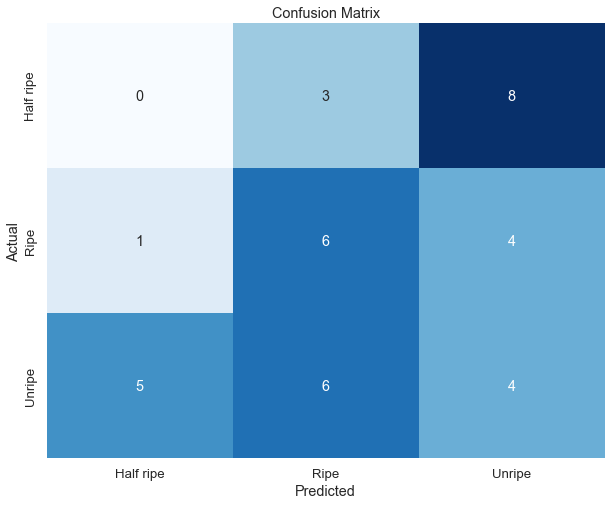

In [28]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
a2 = history.history['accuracy'][-1]
f2 = history.history['f1_score'][-1]
p2 = history.history['precision_m'][-1]
r2 = history.history['recall_m'][-1]

In [30]:
print('Accuracy = ' + str(a2 * 100))
print('Precision = ' + str(p2 * 100))
print('F1 Score = ' + str(f2 * 100))
print('Recall = ' + str(r2 * 100))

Accuracy = 98.51852059364319
Precision = 98.95833134651184
F1 Score = 98.95833134651184
Recall = 98.95833134651184


# Machine Learning

In [31]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
import PIL
import glob
import cv2
import glob as gb

In [32]:
code = {'Half ripe':0 ,'Ripe':1, 'Unripe' : 2}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [33]:
trainpath='output/train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_train.append(list(image_array))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)

In [34]:
testpath='output/val/'

X_test = []
y_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*'))
    for file in files: 
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

In [35]:
loaded_X_train = np.load('X_train.npy')
loaded_X_test = np.load('X_test.npy')
loaded_y_train = np.load('y_train.npy')
loaded_y_test = np.load('y_test.npy')

In [36]:
print(loaded_X_train.shape)

(138, 64, 64, 3)


In [37]:
print(loaded_y_train.shape)
print(loaded_y_test.shape)

(138,)
(37,)


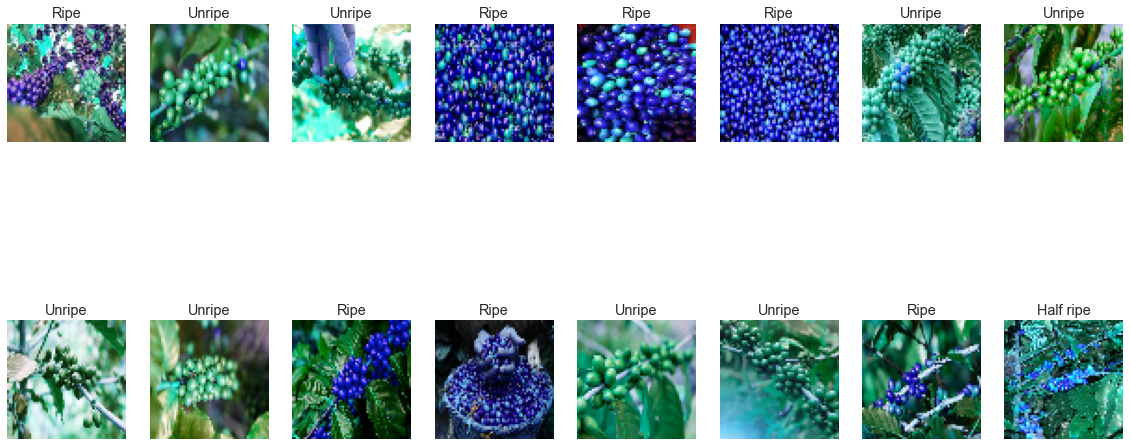

In [38]:
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(loaded_X_train),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_train[i])
    plt.axis('off')
    plt.title(getcode(loaded_y_train[i]))

In [39]:
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)

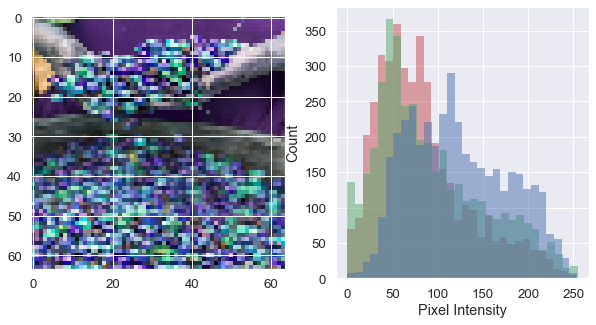

In [40]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

In [41]:
X_train = loaded_X_train.reshape([-1, np.product((64,64,3))])
X_test = loaded_X_test.reshape([-1, np.product((64,64,3))])

In [42]:
y_train = loaded_y_train
y_test = loaded_y_test

In [43]:
from sklearn.utils import shuffle as shf
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, accuracy_score

# KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
predictions = KNN.predict(X_test)
val = (accuracy_score(y_test, predictions) * 100)
print("*Accuracy score for KNN: ", val, "\n")
print("*Confusion Matrix for KNN: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for KNN: ")
print(classification_report(y_test, predictions))

*Accuracy score for KNN:  62.16216216216216 

*Confusion Matrix for KNN: 
[[ 4  0  7]
 [ 2  4  5]
 [ 0  0 15]]
*Classification Report for KNN: 
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       1.00      0.36      0.53        11
           2       0.56      1.00      0.71        15

    accuracy                           0.62        37
   macro avg       0.74      0.58      0.57        37
weighted avg       0.72      0.62      0.59        37



In [46]:
y_pred = KNN.predict(X_test)
a3 = accuracy_score(y_test, y_pred) 

p3, r3, f3, support = precision_recall_fscore_support(y_test, y_pred, average='micro')


# SVM

In [47]:
from sklearn.svm import SVC
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
predictions = svm.predict(X_test)
val1 = (accuracy_score(y_test, predictions) * 100)
print("*Accuracy score for SVM: ", val1, "\n")
print("*Confusion Matrix for SVM: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for SVM: ")
print(classification_report(y_test, predictions))

*Accuracy score for SVM:  40.54054054054054 

*Confusion Matrix for SVM: 
[[ 0  0 11]
 [ 0  0 11]
 [ 0  0 15]]
*Classification Report for SVM: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        11
           2       0.41      1.00      0.58        15

    accuracy                           0.41        37
   macro avg       0.14      0.33      0.19        37
weighted avg       0.16      0.41      0.23        37



In [48]:
y_pred = svm.predict(X_test)
a4 = accuracy_score(y_test, y_pred) 

p4, r4, f4, support = precision_recall_fscore_support(y_test, y_pred, average='micro')

# Decision Tree

In [49]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT.fit(X_train, y_train)
predictions = DT.predict(X_test)
val1 = (accuracy_score(y_test, predictions) * 100)
print("*Accuracy score for DT: ", val1, "\n")
print("*Confusion Matrix for DT: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for DT: ")
print(classification_report(y_test, predictions))

*Accuracy score for DT:  56.75675675675676 

*Confusion Matrix for DT: 
[[ 4  2  5]
 [ 5  5  1]
 [ 1  2 12]]
*Classification Report for DT: 
              precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.56      0.45      0.50        11
           2       0.67      0.80      0.73        15

    accuracy                           0.57        37
   macro avg       0.54      0.54      0.54        37
weighted avg       0.55      0.57      0.56        37



In [50]:
y_pred = DT.predict(X_test)
a5 = accuracy_score(y_test, y_pred) 

p5, r5, f5, support = precision_recall_fscore_support(y_test, y_pred, average='micro')

# Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=2, random_state=0)
RF.fit(X_train, y_train)
predictions = RF.predict(X_test)
val1 = (accuracy_score(y_test, predictions) * 100)
print("*Accuracy score for RF: ", val1, "\n")
print("*Confusion Matrix for RF: ")
print(confusion_matrix(y_test, predictions))
print("*Classification Report for RF: ")
print(classification_report(y_test, predictions))

*Accuracy score for RF:  56.75675675675676 

*Confusion Matrix for RF: 
[[ 1  1  9]
 [ 1  7  3]
 [ 0  2 13]]
*Classification Report for RF: 
              precision    recall  f1-score   support

           0       0.50      0.09      0.15        11
           1       0.70      0.64      0.67        11
           2       0.52      0.87      0.65        15

    accuracy                           0.57        37
   macro avg       0.57      0.53      0.49        37
weighted avg       0.57      0.57      0.51        37



In [52]:
y_pred = RF.predict(X_test)
a6 = accuracy_score(y_test, y_pred) 

p6, r6, f6, support = precision_recall_fscore_support(y_test, y_pred, average='micro')

# Comparison

In [53]:
results ={'Accuracy': [a,a1,a2,a3,a4,a5,a6],
 'Recall':[r,r1,r2,r3,r4,r5,r6],
 'Precision': [p,p1,p2,p3,p4,p5,p6],
  'F1 Score' : [f,f1,f2,f3,f4,f5,f6]}
index = ['MobileNet','CNN','Xception','KNN','SVM','Decision Tree','Random Forest']

In [54]:
results =pd.DataFrame(results,index=index)

In [55]:
print(results)

               Accuracy    Recall  Precision  F1 Score
MobileNet      0.955556  0.841518   0.841518  0.841518
CNN            0.985185  0.989583   0.989583  0.989583
Xception       0.985185  0.989583   0.989583  0.989583
KNN            0.621622  0.621622   0.621622  0.621622
SVM            0.405405  0.405405   0.405405  0.405405
Decision Tree  0.567568  0.567568   0.567568  0.567568
Random Forest  0.567568  0.567568   0.567568  0.567568


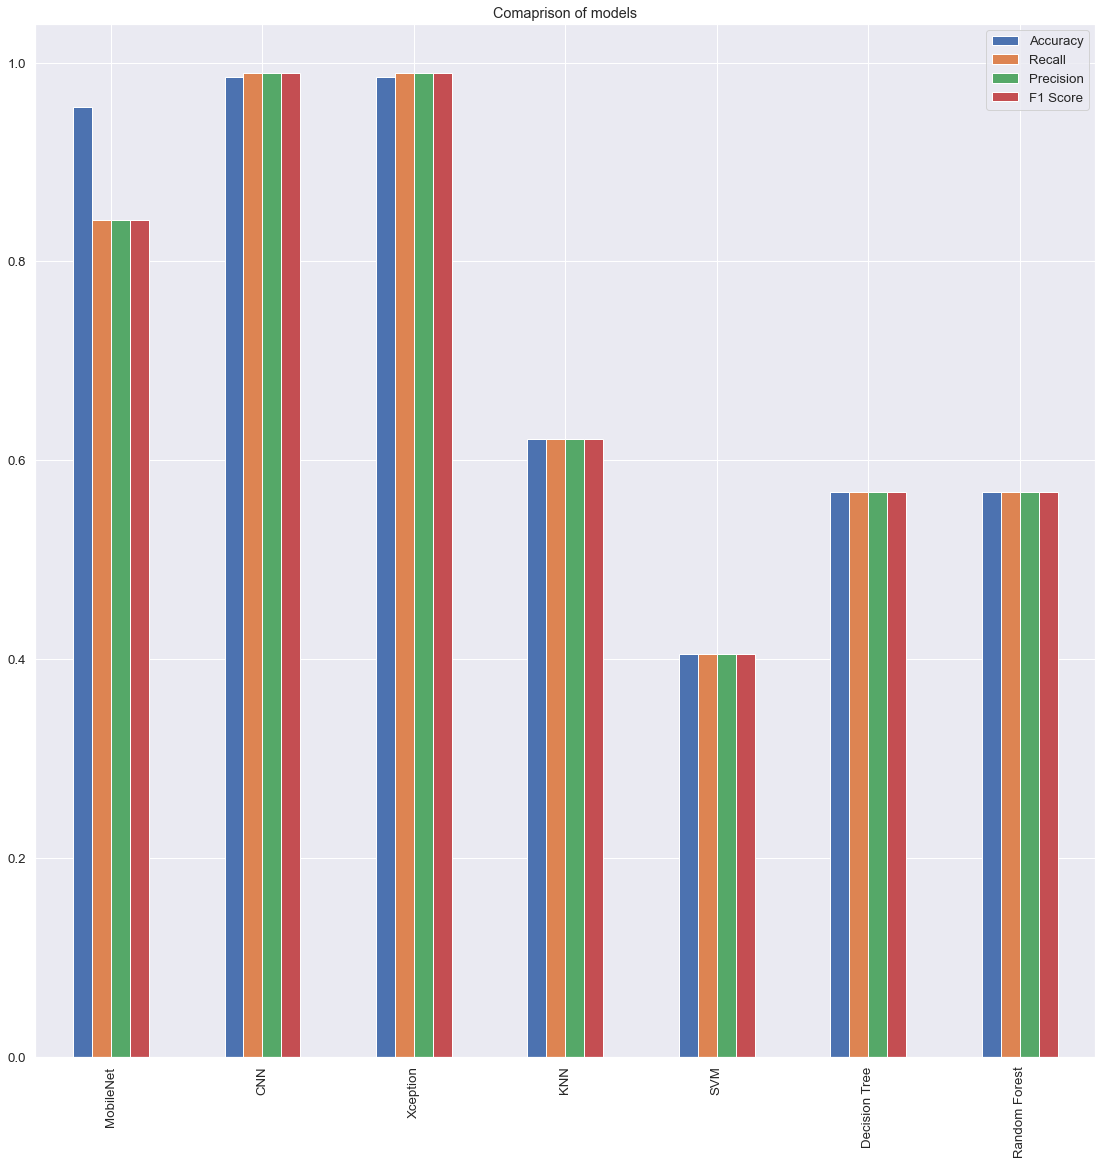

In [56]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

array([<AxesSubplot:title={'center':'Accuracy'}>,
       <AxesSubplot:title={'center':'Recall'}>,
       <AxesSubplot:title={'center':'Precision'}>,
       <AxesSubplot:title={'center':'F1 Score'}>], dtype=object)

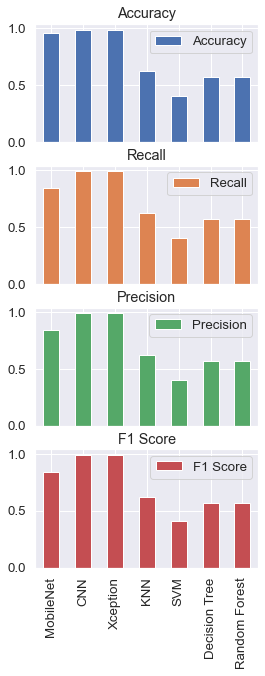

In [57]:
results.plot(subplots=True,kind ='bar',figsize=(4,10))